<a href="https://colab.research.google.com/github/kunalavghade/Ai/blob/main/Week_5_%E2%80%94_Training_Dynamics%2C_Initialization_%26_Optimization_Intuition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 5 — Training Dynamics, Initialization & Optimization Intuition

## Goal
Understand **why neural networks sometimes fail to train**, and how proper initialization, scaling, and optimization choices affect learning.

By the end of this week, you should:
- Understand vanishing and exploding gradients
- Know why initialization matters
- Understand feature scaling
- Develop intuition for training stability
- Write cleaner, modular training code

---

## 1. Training Is a Dynamic System

Training a neural network is **not just math** — it is a **dynamic process**.

Loss changes over time based on:
- Initialization
- Learning rate
- Data scale
- Network depth
- Activation functions

Small choices can make learning:
- Stable
- Slow
- Explosive
- Impossible

---

## 2. The Loss Landscape

The loss function defines a surface over parameter space.

Characteristics:
- High-dimensional
- Non-convex
- Many saddle points

Gradient descent navigates this surface using **local slope information**.

---

## 3. Vanishing Gradients

Problem:
- Gradients shrink as they propagate backward
- Early layers stop learning

Common causes:
- Sigmoid / tanh activations
- Deep networks
- Poor initialization

Effect:
- Very slow or stalled training

---

## 4. Exploding Gradients

Problem:
- Gradients grow exponentially
- Parameters blow up
- Loss becomes NaN

Common causes:
- Large initial weights
- High learning rate
- Deep networks

---

## 5. Why Initialization Matters

If weights are:
- Too small → vanishing gradients
- Too large → exploding gradients

Good initialization:
- Preserves variance across layers
- Stabilizes forward & backward passes

---

## 6. Common Initialization Strategies

### Zero Initialization
- Symmetry problem
- All neurons learn same thing
- Not usable for hidden layers

---

### Random Initialization
- Breaks symmetry
- But scale matters

---

### Xavier (Glorot) Initialization
Designed for tanh / sigmoid:

W ~ N(0, 1 / n_in)

---

### He Initialization
Designed for ReLU:

W ~ N(0, 2 / n_in)

---

## 7. Feature Scaling

If input features have different scales:
- Gradients become skewed
- Optimization becomes inefficient

Common techniques:
- Min–Max Scaling
- Standardization (zero mean, unit variance)

---

## 8. Learning Rate Sensitivity

Learning rate controls step size.

Behavior:
- Too small → slow convergence
- Too large → divergence
- Just right → smooth descent

Learning rate interacts with:
- Initialization
- Activation function
- Data scale

---

## 9. Training Diagnostics

Signs of problems:
- Loss = NaN → exploding gradients
- Flat loss → vanishing gradients
- Oscillating loss → learning rate too high

Plotting loss is **mandatory**, not optional.

---

## 10. Modular Neural Network Design

A clean implementation separates:
- Initialization
- Forward pass
- Backward pass
- Parameter updates

This makes debugging possible.

---

## Coding Questions (NumPy Only)

### Question 1: Initialization Study
Implement:
- Zero initialization
- Random initialization
- Xavier initialization
- He initialization

Compare:
- Loss curves
- Convergence speed

---

### Question 2: Gradient Monitoring
During training:
- Track gradient norms
- Plot gradient magnitude vs epochs

Identify:
- Vanishing gradients
- Exploding gradients

---

### Question 3: Feature Scaling Experiment
Train the same network:
- With unscaled features
- With scaled features

Compare:
- Convergence speed
- Final loss

---

### Question 4: Learning Rate Sweep
Train with multiple learning rates.
Plot:
- Loss vs epochs for each rate

Explain behavior.

---

### Question 5: Refactor Code
Refactor your neural network into:
- Class-based design
- Clear forward/backward methods

---

### Question 6: Stress Testing
Intentionally break training by:
- Using large learning rate
- Using bad initialization

Observe and explain failures.

---

### Question 7: Conceptual (Write Answers)
1. Why does initialization affect gradient flow?
2. Why does ReLU work better than sigmoid in deep networks?
3. Why is feature scaling critical?
4. Why is training unstable sometimes?

---

## Outcome of Week 5

After completing this week, you should:
- Debug training failures confidently
- Choose reasonable initialization strategies
- Understand optimization dynamics
- Write robust neural network code

**Question 1: Initialization Study**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Initialization Functions

In [2]:
def init_zero(n_in, n_out):
  return np.zeros((n_in, n_out))

def init_random(n_in, n_out):
  return np.random.randn(n_in, n_out) * 0.01

def init_xavier(n_in, n_out):
  return np.random.randn(n_in, n_out) * np.sqrt(1 / n_in)

def init_he(n_in, n_out):
  return np.random.randn(n_in, n_out) * np.sqrt(2 / n_in)

Activations

In [3]:
def relu(z):
  return np.maximum(0, z)

def relu_grad(z):
  return (z > 0).astype(float)

def sigmoid(z):
  return 1 / (1 + np.exp(-z))

Neural Network Class (2-layer)

In [5]:
class NeuralNetwork:
  def __init__(self, n_in, n_hidden, lr=0.1, init="he"):
    if init == "zero":
      self.W1 = init_zero(n_in, n_hidden)
    elif init == "random":
      self.W1 = init_random(n_in, n_hidden)
    elif init == "xavier":
      self.W1 = init_xavier(n_in, n_hidden)
    else:
      self.W1 = init_he(n_in, n_hidden)

    self.b1 = np.zeros((1, n_hidden))
    self.W2 = init_he(n_hidden, 1)
    self.b2 = np.zeros((1, 1))
    self.lr = lr

  def forward(self, X):
    self.z1 =  X @ self.W1 + self.b1
    self.a1 = relu(self.z1)
    self.z2 = self.a1 @ self.W2 + self.b2
    self.y_hat = sigmoid(self.z2)
    return self.y_hat

  def backward(self, X, y):
    m = X.shape[0]

    dz2 = self.y_hat - y
    dW2 = (self.a1.T @ dz2) / m
    db2 = np.mean(dz2, axis=0, keepdims=True)
    da1 = dz2 @ self.W2.T
    dz1 = da1 * relu_grad(self.z1)
    dW1 = (X.T @ dz1) / m
    db1 = np.mean(dz1, axis=0, keepdims=True)

    # Store gradient norms (for Q2)
    self.grad_norm = np.linalg.norm(dW1) + np.linalg.norm(dW2)

    # Update
    self.W2 -= self.lr * dW2
    self.b2 -= self.lr * db2
    self.W1 -= self.lr * dW1
    self.b1 -= self.lr * db1





Training Loop

In [8]:
b = 1e-8
def train(model, X, y, epochs=2000):
  losses = []
  grad_norms = []

  for _ in range(epochs):
    y_hat = model.forward(X)
    loss = -np.mean( y * np.log(y_hat + b) + (1 - y) * np.log(1 - y_hat + b))
    model.backward(X, y)

    losses.append(loss)
    grad_norms.append(model.grad_norm)

  return losses, grad_norms

Dataset (XOR)

In [7]:
X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
], dtype=float)

y = np.array([[0], [1], [1], [0]], dtype=float)

**Question 1: Compare Initializations**

In [9]:
inits = ["zero", "random", "xavier", "he"]
results = {}

for init in inits:
    nn = NeuralNetwork(2, 8, lr=0.1, init=init)
    losses, _ = train(nn, X, y)
    results[init] = losses

Plot Loss Curves

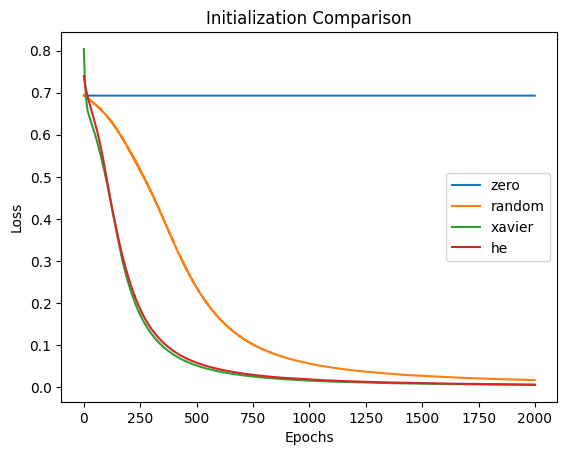

In [12]:
for k, v in results.items():
    plt.plot(v, label=k)

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Initialization Comparison")
plt.show()

**Question 2: Gradient Monitoring**

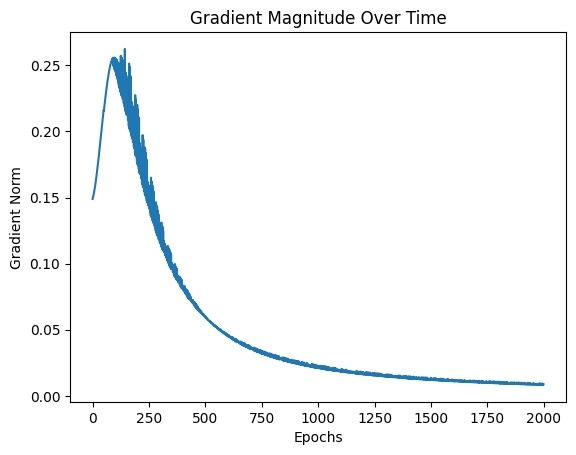

In [13]:
nn = NeuralNetwork(2, 8, lr=0.1, init="he")
losses, grad_norms = train(nn, X, y)

plt.plot(grad_norms)
plt.xlabel("Epochs")
plt.ylabel("Gradient Norm")
plt.title("Gradient Magnitude Over Time")
plt.show()

**Question 3: Feature Scaling Experiment**

In [14]:
X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

Train both and compare loss curves.

In [15]:
inits = ["zero", "random", "xavier", "he"]
results = {}

for init in inits:
    nn = NeuralNetwork(2, 8, lr=0.1, init=init)
    losses, grad = train(nn, X, y)
    results[init] = (losses, grad)

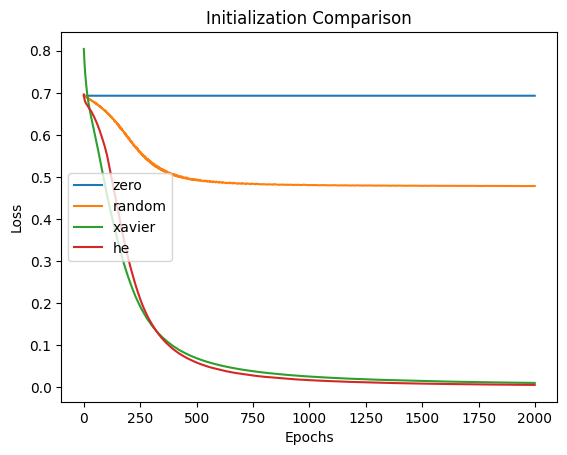

In [16]:
for k, v in results.items():
    plt.plot(v[0], label=k)

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Initialization Comparison")
plt.show()

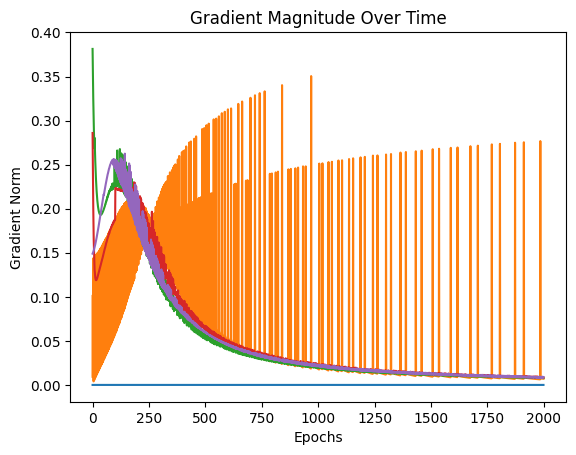

In [17]:
for k, v in results.items():
    plt.plot(v[1], label=k)

plt.plot(grad_norms)
plt.xlabel("Epochs")
plt.ylabel("Gradient Norm")
plt.title("Gradient Magnitude Over Time")
plt.show()

Question 4: Learning Rate Sweep

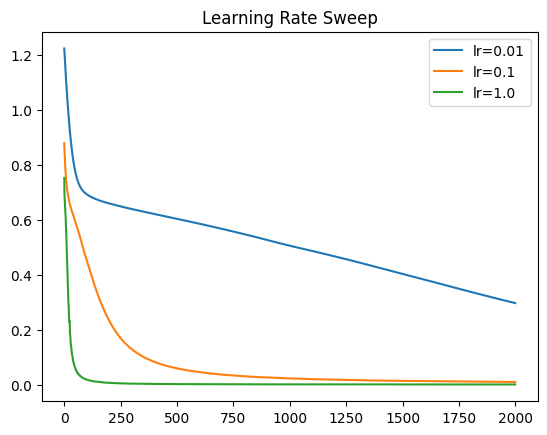

In [18]:
lrs = [0.01, 0.1, 1.0]

for lr in lrs:
    nn = NeuralNetwork(2, 8, lr=lr, init="he")
    losses, _ = train(nn, X, y)
    plt.plot(losses, label=f"lr={lr}")

plt.legend()
plt.title("Learning Rate Sweep")
plt.show()

Question 6: Stress Testing

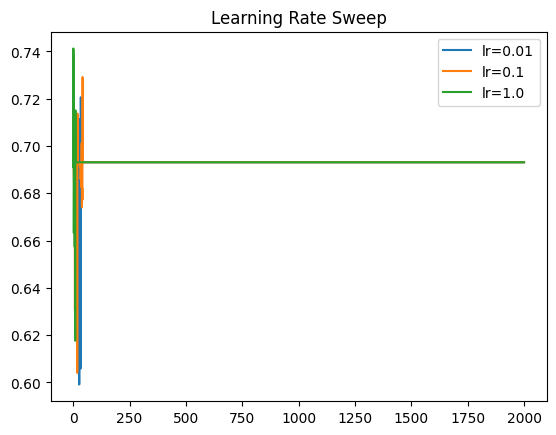

In [19]:
lrs = [0.01, 0.1, 1.0]

for lr in lrs:
    nn = NeuralNetwork(2, 8, lr=5.0, init="random")
    losses, _ = train(nn, X, y)
    plt.plot(losses, label=f"lr={lr}")

plt.legend()
plt.title("Learning Rate Sweep")
plt.show()